In [25]:

# Unified Freight Cost Curve + Invoice Integration Notebook
# ---------------------------------------------------------
# This notebook generates vendor cost curves by site + commodity
# and merges them with invoice data for multi-site freight analysis.

import pandas as pd
import matplotlib.pyplot as plt
import logging
from collections import defaultdict

# --- Logging Setup ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# --- Global Config ---
TIER_BREAKPOINTS = {
    'L5C': 0,
    '5C': 500,
    '1M': 1000,
    '2M': 2000,
    '3M': 3000,
    '5M': 5000,
    '10M': 10000,
    '20M': 20000,
    '30M': 30000,
    '40M': 40000
}

# --- Safe Cleaner for Mixed-Type Numeric Columns ---
def safe_clean_numeric(series):
    if series.dtype == object:
        return pd.to_numeric(series.str.replace(",", ""), errors='coerce')
    return pd.to_numeric(series, errors='coerce')

# --- Load and Structure Vendor Rates ---
def load_and_prepare_rates(rates_file):
    rates_df = pd.read_csv(rates_file)
    rates_df.columns = rates_df.columns.str.strip()
    melted = rates_df.melt(
        id_vars=['site', 'commodity_group'],
        value_vars=[col for col in rates_df.columns if col not in ['site', 'commodity_group']],
        var_name='tier',
        value_name='rate_per_unit'
    )
    rate_map = defaultdict(dict)
    for _, row in melted.iterrows():
        key = (row['site'], row['commodity_group'])
        rate_map[key][row['tier']] = row['rate_per_unit']
    logging.info("Vendor rate table loaded and transformed.")
    return rate_map

# --- Rate Lookup ---
def get_vendor_rate(rate_map, site, commodity, qty):
    tier = max((t for t, cutoff in TIER_BREAKPOINTS.items() if qty >= cutoff), key=lambda x: TIER_BREAKPOINTS[x])
    return rate_map.get((site, commodity), {}).get(tier, 0)

# --- Build Vendor Cost Curve ---
def generate_cost_curve(rate_map, site, commodity):
    if commodity in ["1CBL", "1CPT"]:
        max_qty = 15000
    elif commodity == "1VNL":
        max_qty = 60000
    else:
        max_qty = 40000

    curve = []
    for q in range(0, max_qty + 1):
        rate = get_vendor_rate(rate_map, site, commodity, q)
        if commodity == "1VNL":
            rate = rate / 100  # correct for CWT pricing
        curve.append({
            'site': site,
            'commodity_group': commodity,
            'quantity_sqyd': q,
            'vendor_rate': rate,
            'vendor_estimated_cost': q * rate,
            'source': 'vendor'
        })
    return pd.DataFrame(curve)

# --- Load and Process Invoice Data ---
def load_invoice_data(invoice_file):
    df = pd.read_csv(invoice_file)
    df.columns = df.columns.str.strip()
    df['invoice_row_id'] = df.index + 1
    df['invoice_commodity_quantity'] = pd.to_numeric(df['invoice_commodity_quantity'], errors='coerce')
    df['historical_market_freight_costs'] = safe_clean_numeric(df['historical_market_freight_costs'])
    df['ftl_cost'] = safe_clean_numeric(df['ftl_cost'])
    df['ltl_only_cost'] = safe_clean_numeric(df['ltl_only_cost'])
    df['optimal_cost'] = safe_clean_numeric(df['optimal_cost'])
    df['quantity_sqyd'] = df['invoice_commodity_quantity']
    df['source'] = 'actual'
    logging.info(f"Invoice file loaded with {df.shape[0]} rows.")
    return df

# --- Merge and Export Output ---
def merge_and_export(vendor_curve_df, invoice_df, site, commodity, output_dir):
    filtered_invoice = invoice_df[
        (invoice_df['site'] == site) & 
        (invoice_df['commodity_group'] == commodity)
    ].copy()

    if filtered_invoice.empty:
        logging.warning(f"No matching invoice data for {site} / {commodity}")
        return

    invoice_export = filtered_invoice[[
        'invoice_row_id', 'quantity_sqyd', 'historical_market_freight_costs','ftl_cost',
        'ltl_only_cost', 'optimal_cost'
    ]].copy()
    invoice_export['vendor_rate'] = None
    invoice_export['vendor_estimated_cost'] = None
    invoice_export['source'] = 'actual'

    invoice_export = invoice_export.rename(columns={'historical_market_freight_costs': 'actual_freight_cost'})

    combined_df = pd.concat([vendor_curve_df, invoice_export], ignore_index=True)
    filename = f"{output_dir}/{site}_{commodity}_freight_costs.xlsx"
    combined_df.to_excel(filename, index=False)
    logging.info(f"Exported: {filename}")

# --- Optional Plot ---
# --- Enhanced Plot Function ---
import matplotlib.pyplot as plt
import numpy as np

def plot_cost_curve(vendor_df, invoice_df, siteid, commodity):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Filter vendor cost curve
    vendor_curve = vendor_df[
        (vendor_df['site'] == siteid) & (vendor_df['commodity_group'] == commodity)
    ]

    # Filter invoice data for same site and commodity
    invoice_points = invoice_df[
        (invoice_df['site'] == siteid) & (invoice_df['commodity_group'] == commodity)
    ]

    # Plot vendor step curve
    ax.step(
        vendor_curve['quantity_sqyd'],
        vendor_curve['vendor_estimated_cost'],
        where='post',
        label='Vendor Cost Curve',
        linewidth=2
    )

    # Scatter: actual invoice freight costs
    ax.scatter(
        invoice_points['invoice_commodity_quantity'],
        invoice_points['historical_market_freight_costs'],
        color='gray',
        label='Actual Invoice Freight',
        alpha=0.7
    )

    # Scatter: FTL costs
    x_ftl = invoice_points['invoice_commodity_quantity']
    y_ftl = invoice_points['ftl_cost']
    ax.scatter(x_ftl, y_ftl, color='black', marker='x', label='FTL Cost')

    # Add trendline for FTL
    if len(x_ftl.dropna()) > 1:
        z = np.polyfit(x_ftl, y_ftl, 1)
        p = np.poly1d(z)
        x_range = np.linspace(x_ftl.min(), x_ftl.max(), 100)
        ax.plot(x_range, p(x_range), linestyle='--', color='black', label='FTL Trendline')

    # Scatter: LTL-only costs
    ax.scatter(
        invoice_points['invoice_commodity_quantity'],
        invoice_points['ltl_only_cost'],
        color='deepskyblue',
        marker='o',
        label='LTL Only Cost'
    )

    # Scatter: Optimal costs
    ax.scatter(
        invoice_points['invoice_commodity_quantity'],
        invoice_points['optimal_cost'],
        color='red',
        marker='s',
        label='Optimal Cost'
    )

    # Final formatting
    ax.set_title(f"Freight Cost Overlay - {siteid} / {commodity}")
    ax.set_xlabel("Quantity (SQYD)")
    ax.set_ylabel("Freight Cost ($)")
    ax.legend()
    ax.grid(False)  # 🔻 Grid lines removed
    plt.tight_layout()
    plt.show()

# --- Excel Chart Export ---

# --- Excel Chart Export ---
from openpyxl import Workbook
from openpyxl.chart import ScatterChart, Series, Reference
from openpyxl.utils.dataframe import dataframe_to_rows

def export_freight_chart_excel(df, site, commodity, output_file):
    # Filter only needed columns
    df = df[[
        'quantity_sqyd',
        'vendor_estimated_cost',
        'actual_freight_cost',
        'ftl_cost',
        'ltl_only_cost',
        'optimal_cost'
    ]].copy()

    wb = Workbook()
    ws = wb.active
    ws.title = "Freight Chart"

    for row in dataframe_to_rows(df, index=False, header=True):
        ws.append(row)

    chart = ScatterChart()
    chart.title = f"Freight Cost Overlay - {site} / {commodity}"
    chart.x_axis.title = "Quantity (SQYD)"
    chart.y_axis.title = "Freight Cost ($)"
    chart.legend.position = "t"

    max_row = ws.max_row
    x_values = Reference(ws, min_col=1, min_row=2, max_row=max_row)

    def add_series(title, y_col, marker=None, marker_color=None, line_visible=True):
        y_values = Reference(ws, min_col=y_col, min_row=2, max_row=max_row)
        series = Series(y_values, x_values, title=title)

        if not line_visible:
            series.graphicalProperties.line.noFill = True

        if marker:
            series.marker.symbol = marker
            if marker_color:
                series.marker.graphicalProperties.solidFill = marker_color

        chart.series.append(series)

    add_series("Vendor Cost Curve", 2)
    add_series("Actual Invoice Freight", 3, marker="circle", marker_color="000080", line_visible=False)
    add_series("FTL Cost", 4)
    add_series("LTL Cost", 5, marker="circle", marker_color="000080", line_visible=False)
    add_series("Optimal Cost", 6, marker="circle", marker_color="000080", line_visible=False)

    ws.add_chart(chart, "H2")
    wb.save(output_file)
    print(f"Chart saved to: {output_file}")

2025-05-03 21:31:36,920 - INFO - Vendor rate table loaded and transformed.
2025-05-03 21:31:37,041 - INFO - Invoice file loaded with 8138 rows.
2025-05-03 21:31:50,611 - INFO - Exported: ./freight_output/SPN_1VNL_freight_costs.xlsx


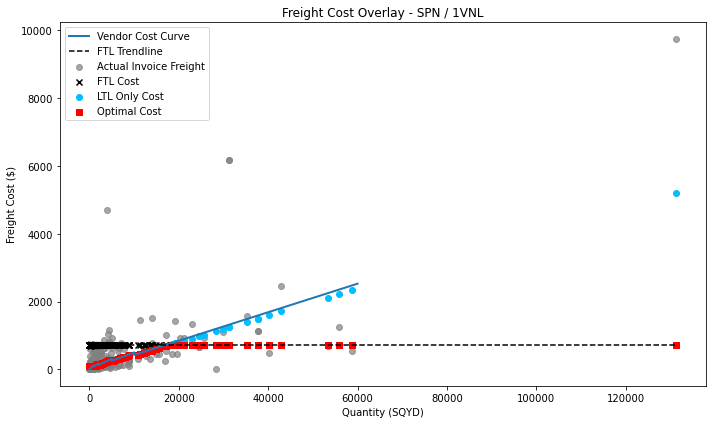

2025-05-03 21:31:57,586 - INFO - Exported: ./freight_output/SPN_1CPT_freight_costs.xlsx


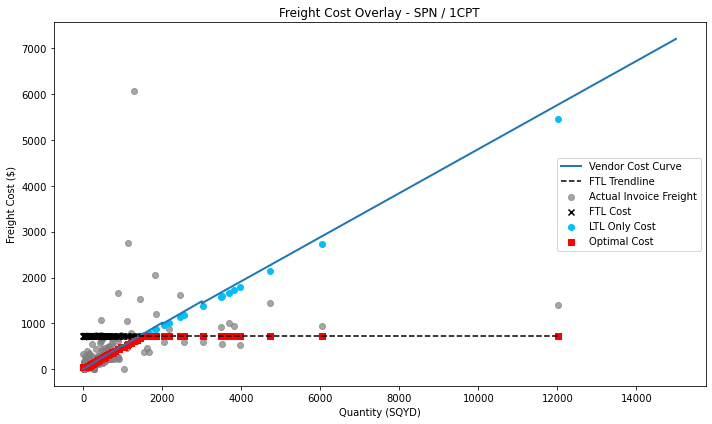

2025-05-03 21:32:07,002 - INFO - Exported: ./freight_output/SPN_1CBL_freight_costs.xlsx


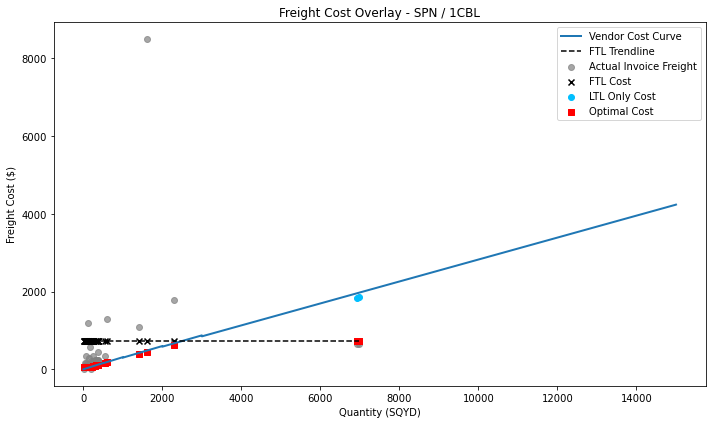

2025-05-03 21:32:31,979 - INFO - Exported: ./freight_output/SPCP_1VNL_freight_costs.xlsx


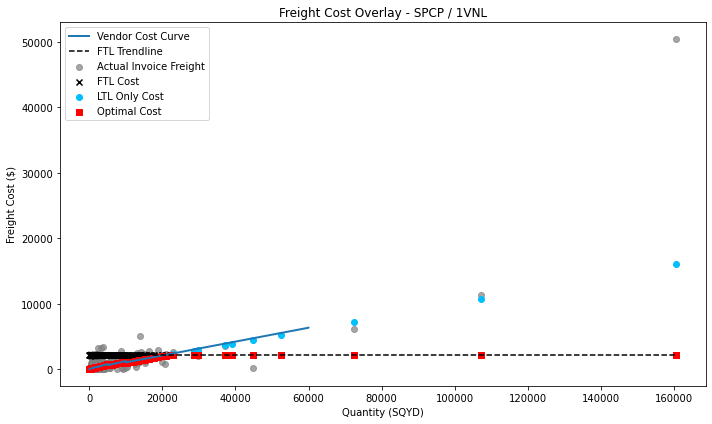

2025-05-03 21:32:39,339 - INFO - Exported: ./freight_output/SPCP_1CPT_freight_costs.xlsx


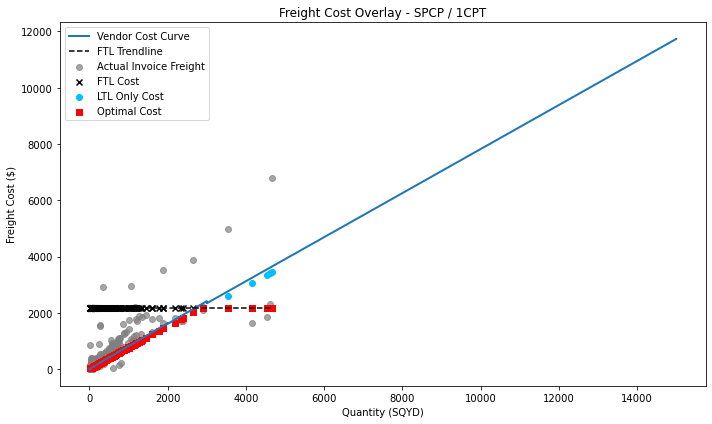

2025-05-03 21:32:49,876 - INFO - Exported: ./freight_output/SPCP_1CBL_freight_costs.xlsx


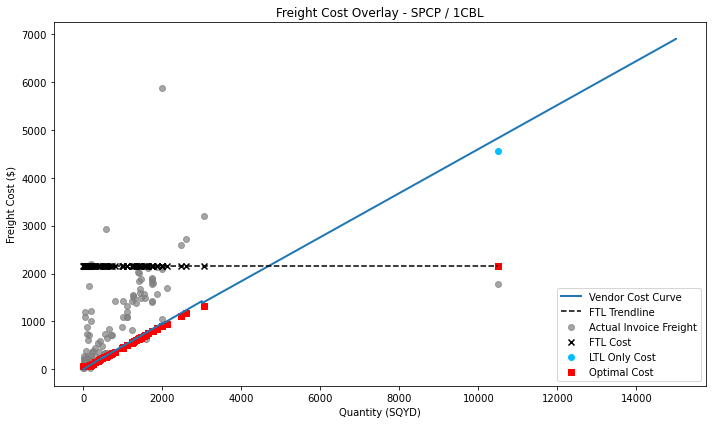

2025-05-03 21:32:58,793 - INFO - Exported: ./freight_output/SPTM_1CPT_freight_costs.xlsx


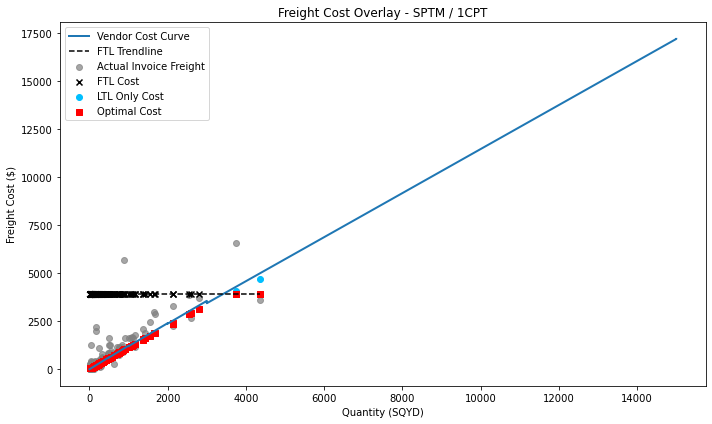

2025-05-03 21:33:08,788 - INFO - Exported: ./freight_output/SPTM_1CBL_freight_costs.xlsx


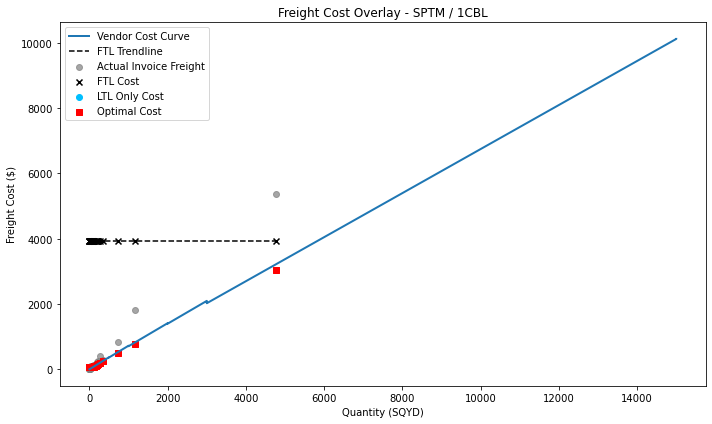

2025-05-03 21:33:33,163 - INFO - Exported: ./freight_output/SPTM_1VNL_freight_costs.xlsx


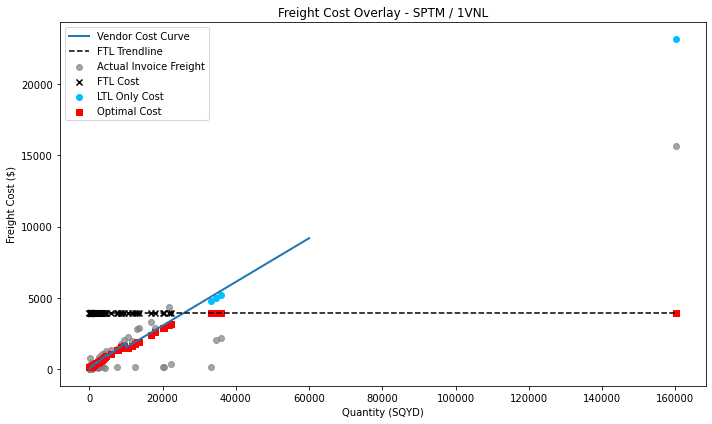

2025-05-03 21:33:55,913 - INFO - Exported: ./freight_output/SPT_1VNL_freight_costs.xlsx


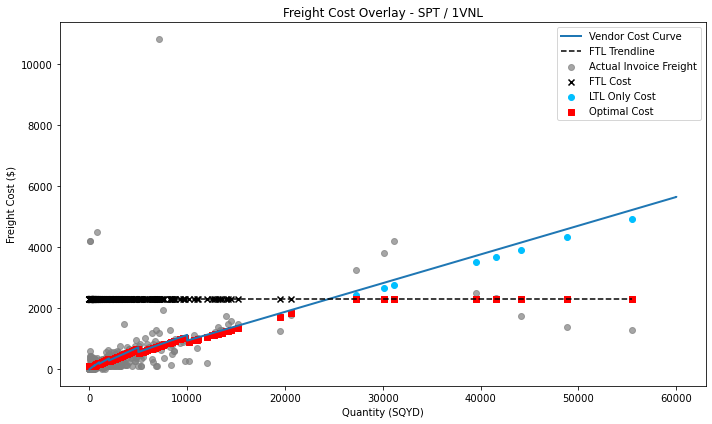

2025-05-03 21:34:05,152 - INFO - Exported: ./freight_output/SPT_1CPT_freight_costs.xlsx


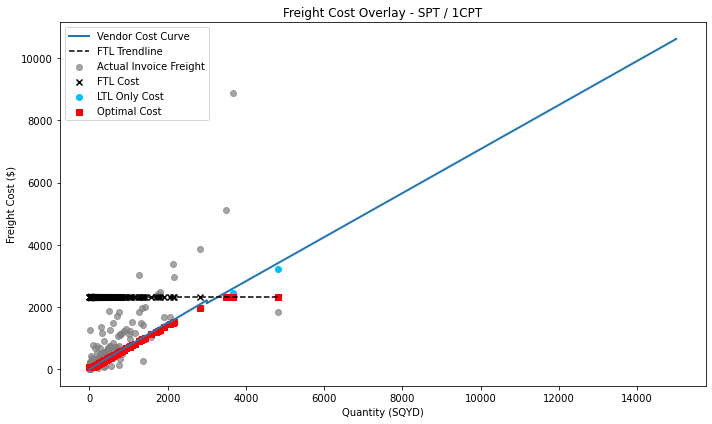

2025-05-03 21:34:13,665 - INFO - Exported: ./freight_output/SPT_1CBL_freight_costs.xlsx


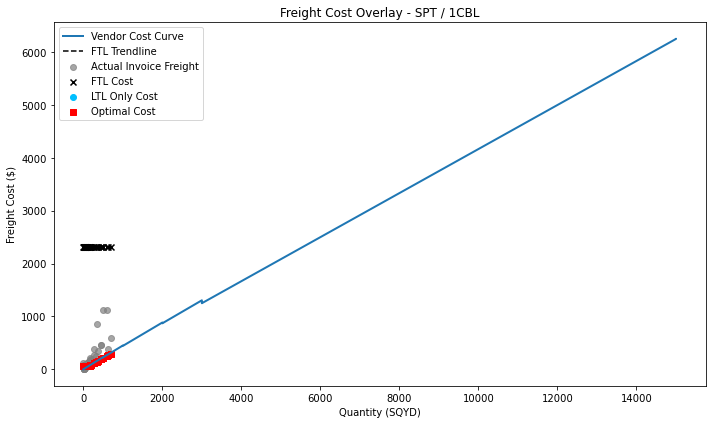

2025-05-03 21:34:39,826 - INFO - Exported: ./freight_output/SPJ_1VNL_freight_costs.xlsx


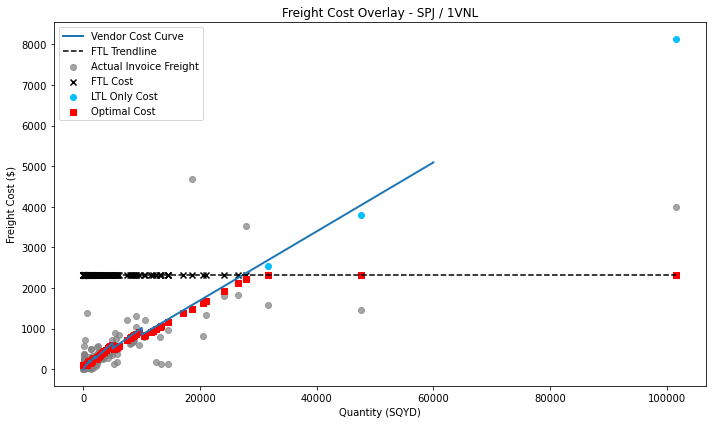

2025-05-03 21:34:46,232 - INFO - Exported: ./freight_output/SPJ_1CPT_freight_costs.xlsx


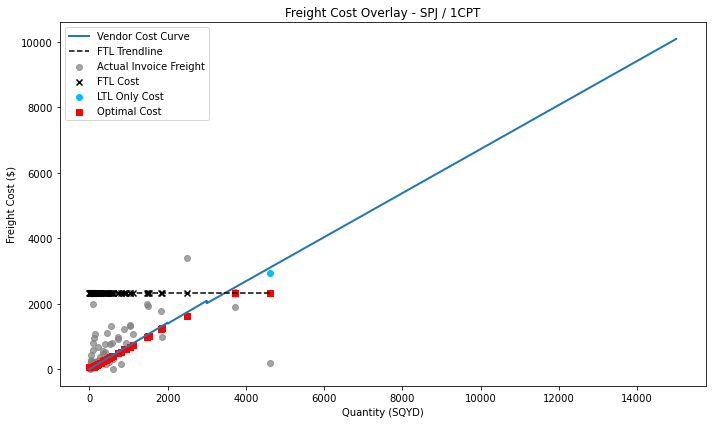

2025-05-03 21:34:53,447 - INFO - Exported: ./freight_output/SPJ_1CBL_freight_costs.xlsx


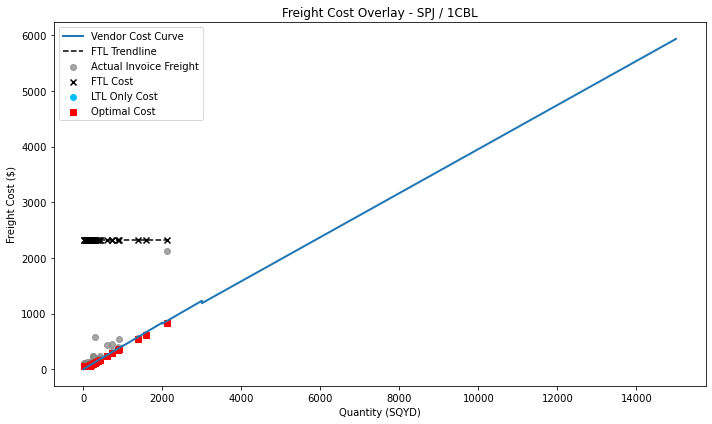

2025-05-03 21:35:00,072 - INFO - Exported: ./freight_output/SPW_1CPT_freight_costs.xlsx


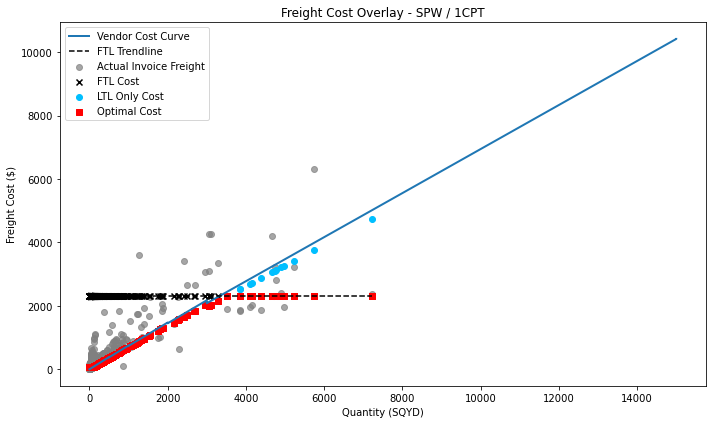

2025-05-03 21:35:23,629 - INFO - Exported: ./freight_output/SPW_1VNL_freight_costs.xlsx


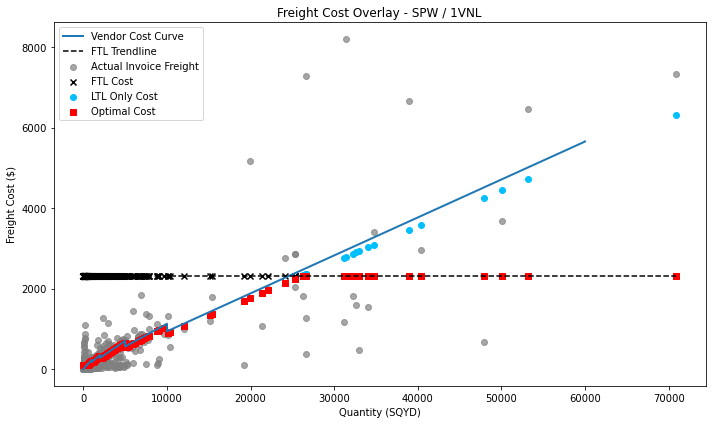

2025-05-03 21:35:30,701 - INFO - Exported: ./freight_output/SPW_1CBL_freight_costs.xlsx


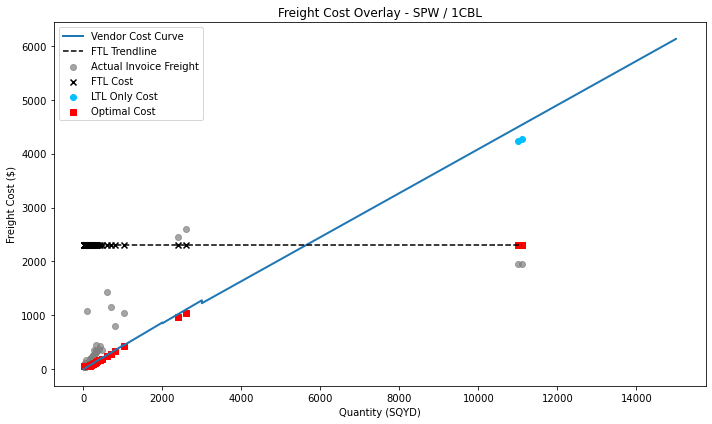

2025-05-03 21:35:55,034 - INFO - Exported: ./freight_output/SPHU_1VNL_freight_costs.xlsx


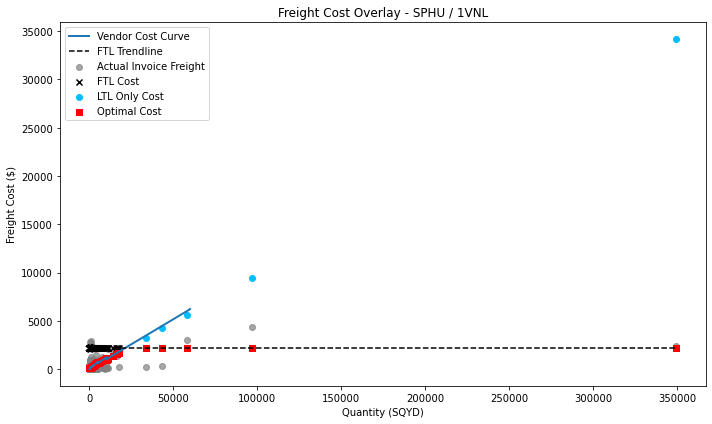

2025-05-03 21:36:03,204 - INFO - Exported: ./freight_output/SPHU_1CPT_freight_costs.xlsx


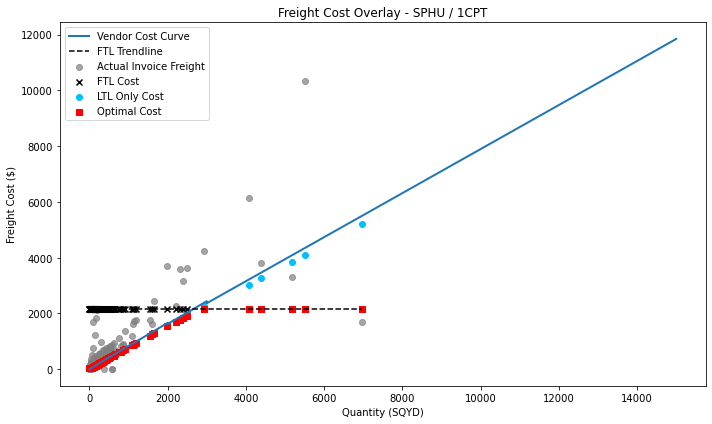

2025-05-03 21:36:09,747 - INFO - Exported: ./freight_output/SPHU_1CBL_freight_costs.xlsx


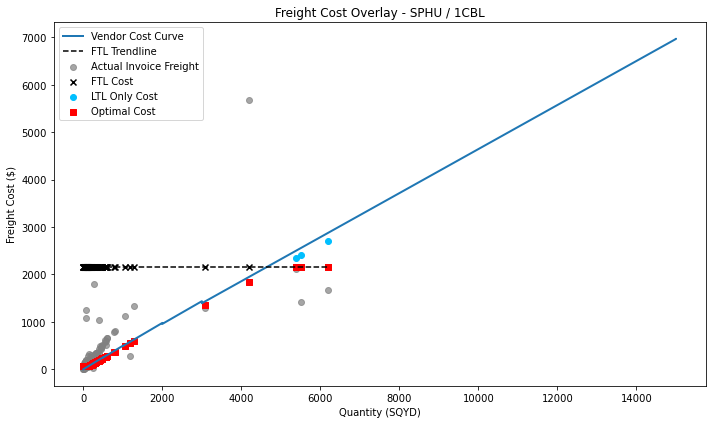

2025-05-03 21:36:17,530 - INFO - Exported: ./freight_output/FSU_1CPT_freight_costs.xlsx


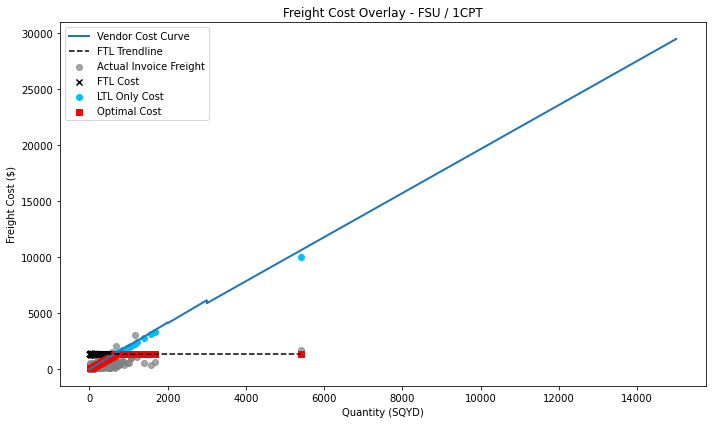

2025-05-03 21:36:40,500 - INFO - Exported: ./freight_output/FSU_1VNL_freight_costs.xlsx


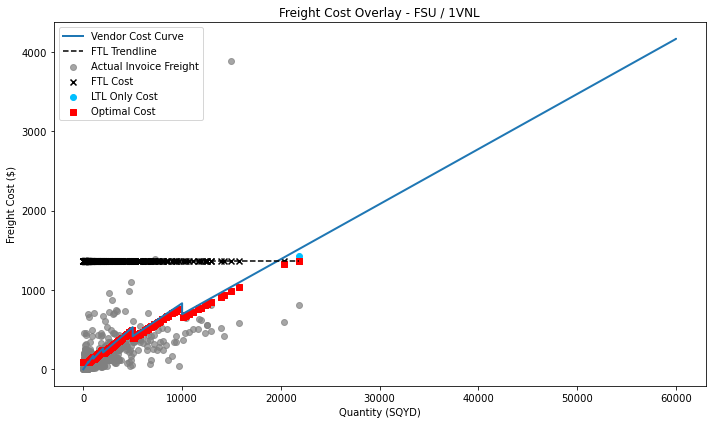

2025-05-03 21:36:48,483 - INFO - Exported: ./freight_output/FSU_1CBL_freight_costs.xlsx


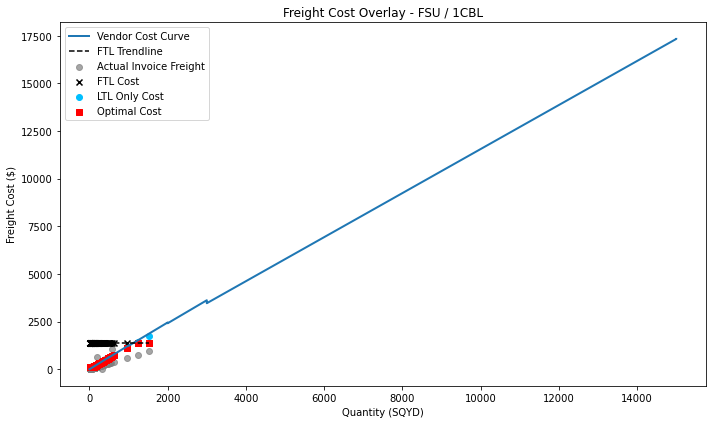

2025-05-03 21:36:54,343 - INFO - Exported: ./freight_output/CTS_1CPT_freight_costs.xlsx


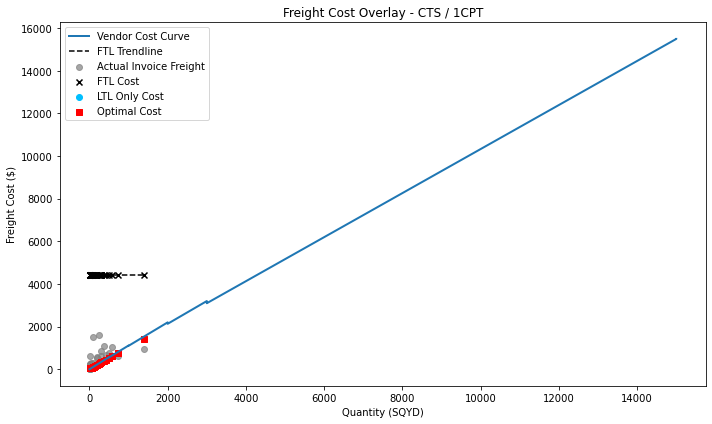

2025-05-03 21:37:16,748 - INFO - Exported: ./freight_output/CTS_1VNL_freight_costs.xlsx


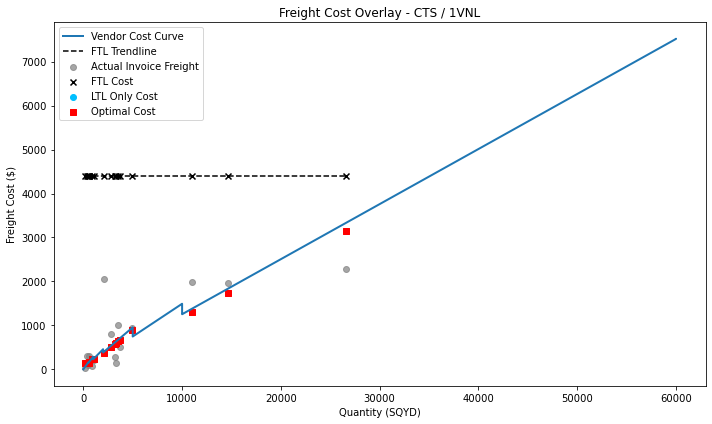

2025-05-03 21:37:23,565 - INFO - Exported: ./freight_output/CTS_1CBL_freight_costs.xlsx


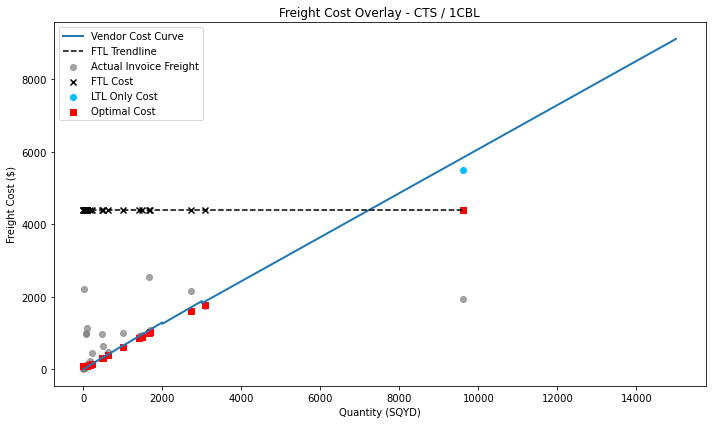

2025-05-03 21:37:30,409 - INFO - Exported: ./freight_output/PVF_1CPT_freight_costs.xlsx


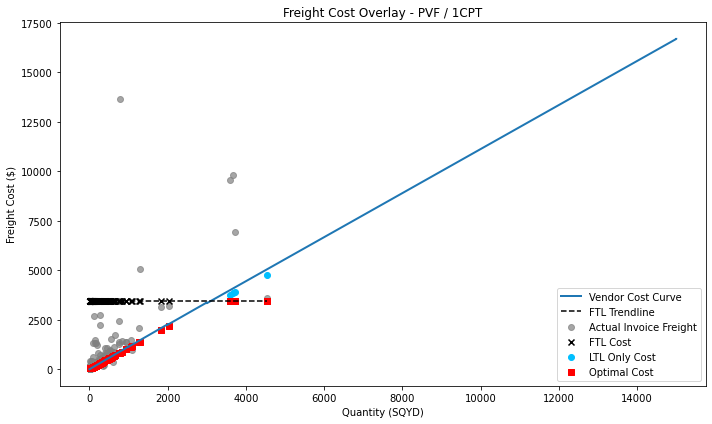

2025-05-03 21:37:37,268 - INFO - Exported: ./freight_output/PVF_1CBL_freight_costs.xlsx


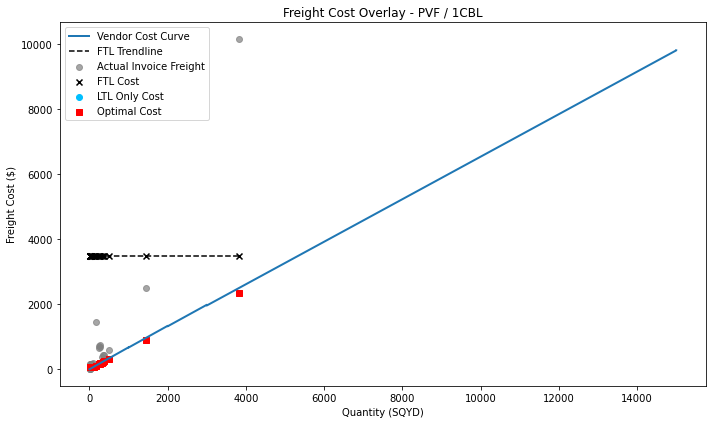

2025-05-03 21:38:00,541 - INFO - Exported: ./freight_output/PVF_1VNL_freight_costs.xlsx


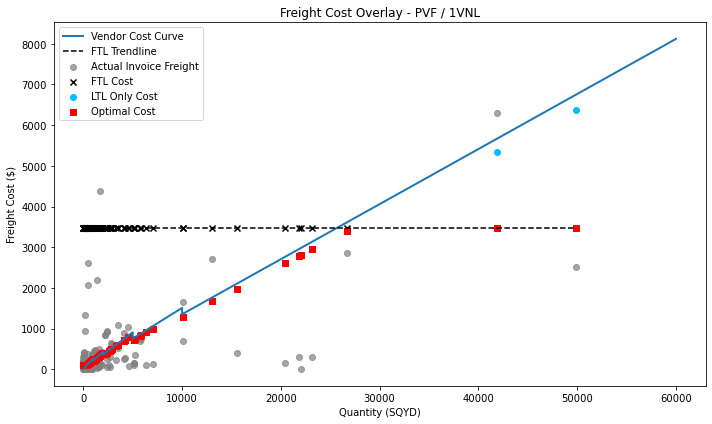

2025-05-03 21:38:22,957 - INFO - Exported: ./freight_output/DIT_1VNL_freight_costs.xlsx


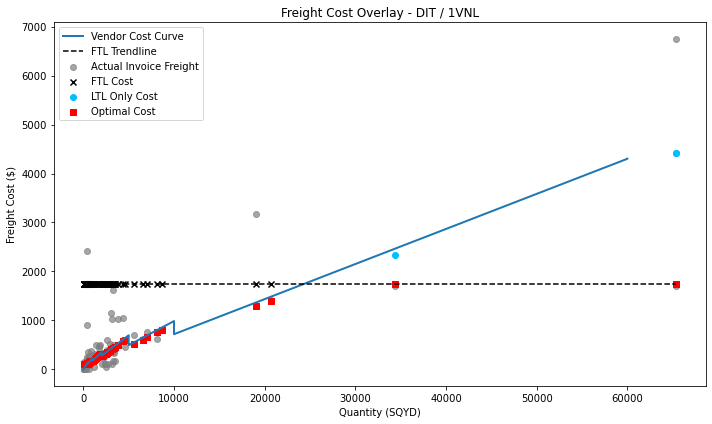

2025-05-03 21:38:30,068 - INFO - Exported: ./freight_output/DIT_1CPT_freight_costs.xlsx


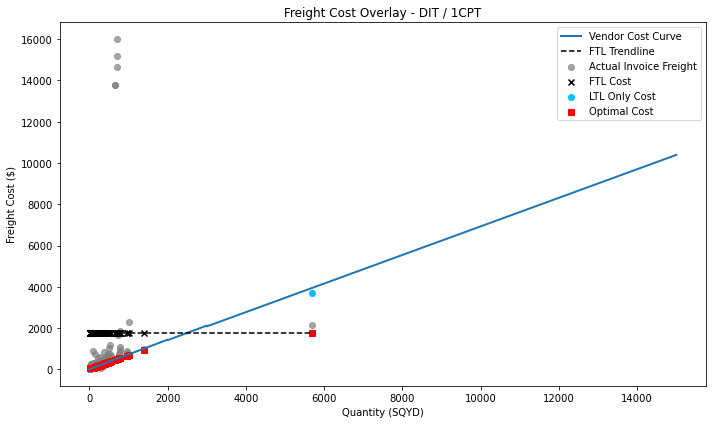

2025-05-03 21:38:36,298 - INFO - Exported: ./freight_output/DIT_1CBL_freight_costs.xlsx


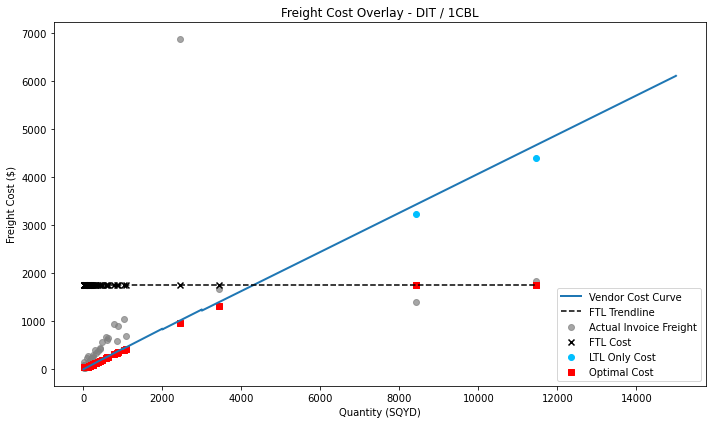

In [26]:
# Assuming rate_map, invoice_df, and generate_cost_curve are already defined
# Also assumes export_freight_chart_excel is defined (from earlier cell)
import os


# --- Step 1: Define file paths ---
rates_file = "../../data/input/freight_model/freight_rates_operating.csv"
invoice_file = "../../data/downloads/rates_adjusted_baseline_xgs_output_03052025.csv"
output_dir = "output_freight_analysis"

# Ensure output folder exists
os.makedirs(output_dir, exist_ok=True)

# --- Step 2: Load rates and invoice data ---
rate_map = load_and_prepare_rates(rates_file)
invoice_df = load_invoice_data(invoice_file)

output_dir = "./freight_output"
os.makedirs(output_dir, exist_ok=True)

for site in invoice_df['site'].unique():
    site_data = invoice_df[invoice_df['site'] == site]
    for commodity in site_data['commodity_group'].unique():
        curve_df = generate_cost_curve(rate_map, site, commodity)
        merge_and_export(curve_df, invoice_df, site, commodity, output_dir)

        # Merge vendor + invoice data for charting
        invoice_subset = invoice_df[(invoice_df['site'] == site) & (invoice_df['commodity_group'] == commodity)].copy()
        invoice_subset = invoice_subset.rename(columns={
            'historical_market_freight_costs': 'actual_freight_cost'
        })
        plot_ready_df = pd.concat([curve_df, invoice_subset], ignore_index=True)

        # Create Excel chart output
        excel_chart_file = os.path.join(output_dir, f"{site}_{commodity}_freight_costs_with_chart.xlsx")
       # export_freight_chart_excel(plot_ready_df, site, commodity, excel_chart_file)

        # Optional: Plot inline as visual confirmation
        plot_cost_curve(curve_df, invoice_df, site, commodity)